In [42]:
import pandas as pd
google = pd.read_excel('https://raw.githubusercontent.com/ywchiu/tibame_tm/master/data/google_comments.xlsx', index_col = 0)

In [43]:
google.head()

,username,score,comment
0,倪依芙,5,起初找不到入口，還以為沒座位，但是原來入口在旁邊樓梯～座位區不大，但是料理很好吃～肉圓的醬微...
1,Mimi龍,4,聞名已久，今天特別來現場試試，目前改成點餐機點餐， ⋯⋯更多聞名已久，今天特別來現場試試，目...
2,林昌逸,1,非常生氣服務員的態度😠服務很糟糕，麵都還沒吃完，一起身就把麵收走，擺明趕客人😡😡😡
3,林幸蓁,5,內用與外帶有不同的點餐方式內用須至店內使用機台點菜、輸入桌號並付款外帶好像只需在入口處點餐即...
4,台灣TAXI市區叫車禮車包車約拍找小鄭,5,乾淨衛生，廁所很大在地下室，有免費飲料可以喝，拉麵愛好吃，麻辣豆腐不錯、肉粽不錯，目前吃過很...


In [44]:
def convertScore(score):
  if int(score) >= 4:
    return 'good'
  elif int(score) <= 2:
    return 'bad'
  else:
    return 'soso'

In [45]:
google['status'] = google['score'].map(lambda e: convertScore(e))

In [46]:
google.head()

,username,score,comment,status
0,倪依芙,5,起初找不到入口，還以為沒座位，但是原來入口在旁邊樓梯～座位區不大，但是料理很好吃～肉圓的醬微...,good
1,Mimi龍,4,聞名已久，今天特別來現場試試，目前改成點餐機點餐， ⋯⋯更多聞名已久，今天特別來現場試試，目...,good
2,林昌逸,1,非常生氣服務員的態度😠服務很糟糕，麵都還沒吃完，一起身就把麵收走，擺明趕客人😡😡😡,bad
3,林幸蓁,5,內用與外帶有不同的點餐方式內用須至店內使用機台點菜、輸入桌號並付款外帶好像只需在入口處點餐即...,good
4,台灣TAXI市區叫車禮車包車約拍找小鄭,5,乾淨衛生，廁所很大在地下室，有免費飲料可以喝，拉麵愛好吃，麻辣豆腐不錯、肉粽不錯，目前吃過很...,good


In [47]:
import jieba
corpus = []
tags = []
for idx, rec in google[google['status'].isin(['good', 'bad'])].iterrows():
  corpus.append(' '.join(jieba.cut(rec.get('comment'))))
  tags.append(rec.get('status'))

## TF-IDF

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
y = tags

In [49]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y =  train_test_split(X,y, test_size = 0.3, random_state = 42)

## Naive Bayes - clf1

In [50]:
from sklearn.naive_bayes import MultinomialNB
clf1 = MultinomialNB(alpha = 0.01)
clf1.fit(train_x, train_y)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix
predicted1 = clf1.predict(test_x)

## Naive Bayes(clf1) - Accuracy Score

In [52]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(test_y, predicted1)

0.8257575757575758

In [53]:
confusion_matrix(test_y, predicted1)

array([[43, 12],
       [11, 66]])

## SVM - clf2


In [54]:
from sklearn.svm import SVC
clf2 = SVC(kernel = 'linear', probability=True)
clf2.fit(train_x, train_y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [55]:
predicted2 = clf2.predict(test_x)

## SVM(clf2) - Accuracy Score

In [56]:
accuracy_score(test_y, predicted2)

0.8484848484848485

In [57]:
confusion_matrix(test_y, predicted2)

array([[47,  8],
       [12, 65]])

## Word2Vec

In [58]:
import jieba
corpus_clf3 = []
for e in google['comment'].tolist():
    corpus_clf3.append(list(jieba.cut(e)))

In [59]:
from gensim.models import word2vec
size = 300  # 產生多少維度 
min_count = 3 # 要算至少出現多少次數的字詞
workers = -1 # 使用多少個core 計算, -1 使用所有的core 進行計算 
window = 10  # 上下文的區間
iter = 1000 # 神經網路訓練的迭代數
sample = 1e-5 # 取樣的數量
model = word2vec.Word2Vec(corpus_clf3, 
                          workers = workers,
                          sample = sample,
                          size = size,
                          min_count=min_count,
                          window = window,
                          iter = iter)

In [60]:
import jieba
corpus = []
tags = []
for idx, rec in google[google['status'].isin(['good', 'bad'])].iterrows():
  corpus.append(' '.join(jieba.cut(rec.get('comment'))))
  tags.append(rec.get('status'))

In [61]:
import numpy as np
x = []
y = []
size = 300
for tag, s in zip(tags, corpus):
    vec = np.zeros(size).reshape((1, size))
    cnt = 0
    for w in s:
        if w in model:
            vec += model.wv.get_vector(w)
            cnt += 1
    if cnt > 0:
      x.append(vec / cnt)
      y.append(tag)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':


In [62]:
x = np.concatenate(x, axis = 0)

In [63]:
x.shape

(440, 300)

In [64]:
len(x)

440

In [65]:
from sklearn.model_selection import train_test_split
train_x_clf3, test_x_clf3, train_y_clf3, test_y_clf3 = train_test_split(x,y, test_size = 0.3, random_state = 42)

## SVM - clf3

In [66]:
from sklearn.svm import SVC
clf3 = SVC(kernel = 'rbf' , probability=True)
clf3.fit(train_x_clf3, train_y_clf3)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [67]:
predicted3 = clf3.predict(test_x_clf3)

## SVM(clf3) - Accuracy Score

In [68]:
accuracy_score(test_y_clf3, predicted3)

0.75

In [69]:
confusion_matrix(test_y_clf3, predicted3)

array([[48,  7],
       [26, 51]])

## BERT

In [70]:
df = google.loc[google['status'].isin(['good', 'bad']), ['comment', 'status']]

In [71]:
df['status'] = df['status'].replace({'good':1,'bad':0})

In [72]:
df.head()

,comment,status
0,起初找不到入口，還以為沒座位，但是原來入口在旁邊樓梯～座位區不大，但是料理很好吃～肉圓的醬微...,1
1,聞名已久，今天特別來現場試試，目前改成點餐機點餐， ⋯⋯更多聞名已久，今天特別來現場試試，目...,1
2,非常生氣服務員的態度😠服務很糟糕，麵都還沒吃完，一起身就把麵收走，擺明趕客人😡😡😡,0
3,內用與外帶有不同的點餐方式內用須至店內使用機台點菜、輸入桌號並付款外帶好像只需在入口處點餐即...,1
4,乾淨衛生，廁所很大在地下室，有免費飲料可以喝，拉麵愛好吃，麻辣豆腐不錯、肉粽不錯，目前吃過很...,1


In [73]:
from sklearn.model_selection import train_test_split
train_df, eval_df = train_test_split(df, test_size = 0.3, random_state = 42)

In [74]:
! pip install simpletransformers

In [75]:
from simpletransformers.classification import ClassificationModel
clf4 = ClassificationModel('bert', 'bert-base-chinese')

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [76]:
clf4.train_model(train_df, args = {'overwrite_output_dir' : True})

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:304: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


In [77]:
result, model_output, wrong_predictions = clf4.eval_model(eval_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:776: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [78]:
result

{'eval_loss': 0.15900889652616837,
 'fn': 5,
 'fp': 1,
 'mcc': 0.9091870627809201,
 'tn': 54,
 'tp': 72}

## BERT(clf4) - Accuracy Score

In [79]:
(result['tn'] + result['tp']) / (result['tn'] + result['tp'] + result['fn'] + result['fp'] )

0.9545454545454546

## ROC Curve & AUC(右下角)

In [80]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:776: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


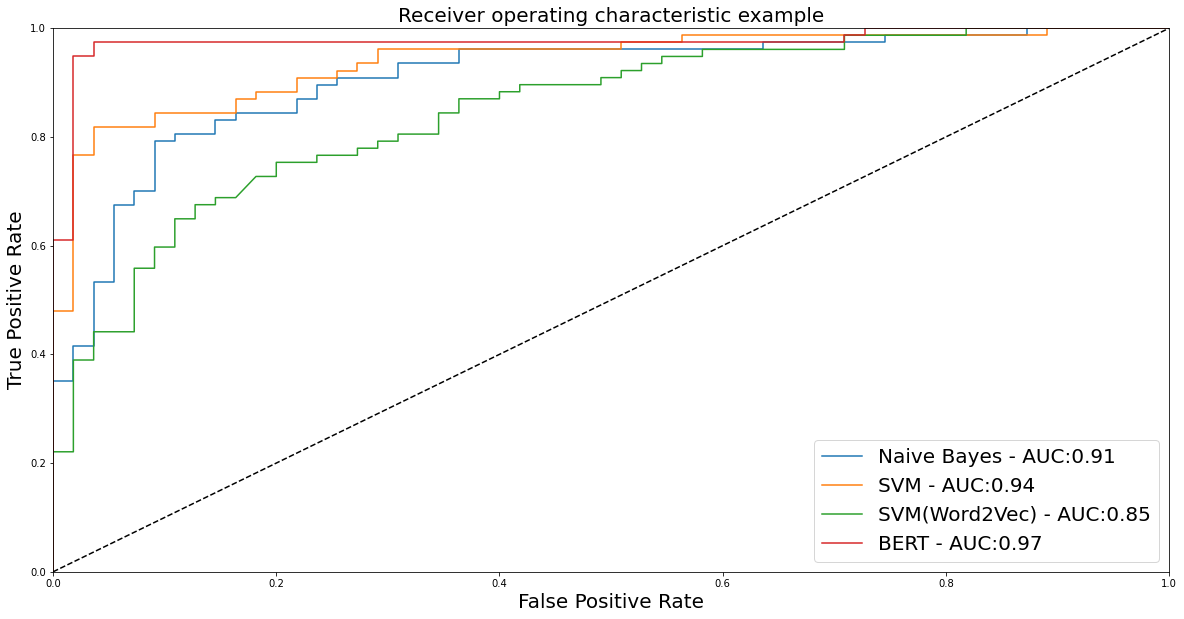

In [81]:
plt.figure(figsize= [20,10])
for clf, title in zip([clf1, clf2, clf3, clf4], ['Naive Bayes', 'SVM', 'SVM(Word2Vec)', 'BERT']):
  if title == 'Naive Bayes' or  title == 'SVM':
    probas_ = clf.fit(train_x, train_y).predict_proba(test_x)
    test_y2 = np.array([1 if e == 'good' else 0 for e in test_y])
    fpr, tpr, thresholds = roc_curve(test_y2, probas_[:, 1])
    plt.plot(fpr, tpr, label='%s - AUC:%.2f'%(title, auc(fpr, tpr)) )

  elif title == 'SVM(Word2Vec)':
    probas_ = clf.fit(train_x_clf3, train_y_clf3).predict_proba(test_x_clf3)
    test_y2 = np.array([1 if e == 'good' else 0 for e in test_y_clf3])
    fpr, tpr, thresholds = roc_curve(test_y2, probas_[:, 1])
    plt.plot(fpr, tpr, label='%s - AUC:%.2f'%(title, auc(fpr, tpr)) )

  else:
    # BERT MODEL
    result, model_output, wrong_predictions = clf4.eval_model(eval_df)
    fpr2, tpr2, threshold2 = roc_curve(eval_df['status'], model_output[:,1])
    plt.plot(fpr2, tpr2, label='%s - AUC:%.2f'%(title, auc(fpr2, tpr2)) )

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Receiver operating characteristic example', fontsize = 20)
plt.legend(loc="lower right", fontsize = 20)
plt.show()